# Fake News Detection with TF-IDF and Logistic Regression

In this notebook, I build a simple but effective text classification model to detect fake news articles. Fake news detection is a very relevant problem today, and I wanted to see how basic text processing and machine learning can be applied to a real dataset. Working on this project helped me go through the whole workflow, from cleaning the data to training a model and evaluating its performance.

As a beginner in data analysis, my main goals are to:

- Practice an end-to-end NLP pipeline (from raw text to predictions),
- Understand how classical machine learning models behave on text data,
- Explain each step in a clear and intuitive way, so that someone at my level can follow it.

# Importing Libraries

In this section I import the main Python libraries I use in the project:

- **Pandas / numpy** – working with tabular data.
- **Re, nltk** – basic natural language processing and text cleaning.
- **Scikit-learn (sklearn)** – splitting the data, vectorizing the text, training the model and evaluating it.

I intentionally start with the classic `scikit-learn` stack instead of deep learning,  
because it is easier to understand for a beginner and still very powerful for this kind of problem.

In [1]:
# Comment out if not needed
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import numpy as np

import re
import nltk
nltk.download('wordnet')


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...


# Loading and Combining the Data

The dataset provides two CSV files:

- one with **fake** news articles,
- one with **real** news articles.

I load both files with `pandas` and then:

- add a new column called `label`  
  - `0` means *fake*  
  - `1` means *real*
- concatenate the two dataframes into a single dataframe called `df`.

By doing this I create a unified dataset where each row contains:
- the text of an article, and
- the corresponding label saying whether it is fake or real.

In [3]:
fake = pd.read_csv("data/Fake.csv")
real = pd.read_csv("data/True.csv")

fake['label'] = 0   # 0 = FAKE
real['label'] = 1   # 1 = REAL

df = pd.concat([fake, real], axis=0).reset_index(drop=True)
df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


# Selecting Text and Label Columns

The original CSV files contain several columns (such as title, subject, date, etc.).  
For this first version of the model I keep it simple and only use:

- **`text`** – the full content of the news article,
- **`label`** – the target (0 = fake, 1 = real).

I also drop any rows with missing values.

Focusing on a small number of features helps me:

- Understand the core idea of text classification,
- Avoid unnecessary noise,
- And keep the model easier to explain.


In [4]:
df = df[['text', 'label']].dropna()
df.head(), df['label'].value_counts()

(                                                text  label
 0  Donald Trump just couldn t wish all Americans ...      0
 1  House Intelligence Committee Chairman Devin Nu...      0
 2  On Friday, it was revealed that former Milwauk...      0
 3  On Christmas day, Donald Trump announced that ...      0
 4  Pope Francis used his annual Christmas Day mes...      0,
 label
 0    23481
 1    21417
 Name: count, dtype: int64)

# Text Cleaning

Raw text is messy. Before training a model, I clean the text to make it more suitable for machine learning.
The dataset contains noisy text such as punctuation, URLs, and repeated characters.
Cleaning this properly is important because noise can distract the model from the actual meaning of the news content.

In my `clean_text` function, I do the following steps:

1. **Remove URLs**  
   Links like `http://...` usually do not help to decide if the news is fake or real.

2. **Keep only letters**  
   I remove numbers and special characters and keep only `a–z` letters.  
   This simplifies the vocabulary for this first version of the model.

3. **Lowercasing**  
   I convert everything to lowercase so that `Trump`, `TRUMP` and `trump` are treated as the same word.

4. **Tokenization and stopword removal**  
   I split the text into words and removed common English stopwords  
   (words like *the, is, and* which appear everywhere and do not carry much meaning).

5. **Lemmatization**  
   I reduce words to their base form using WordNetLemmatizer,  
   so that *running*, *runs* and *ran* all become *run*.

These steps reduce noise and make it easier for the model to learn patterns in the text.  
There are many alternative preprocessing choices (stemming, keeping punctuation, using spaCy, etc.),  
But for a beginner project, this pipeline is a good balance between simplicity and quality.

**Important Note**

This model is designed for English text only. If the dataset contained articles in other languages, additional preprocessing steps such as language detection or separate tokenization rules would be required.


In [5]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = text.lower()
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

In [8]:
df['clean_text'] = df['text'].apply(clean_text)
df.head()

,text,label,clean_text
0,Donald Trump just couldn t wish all Americans ...,0,donald trump wish american happy new year leav...
1,House Intelligence Committee Chairman Devin Nu...,0,house intelligence committee chairman devin nu...
2,"On Friday, it was revealed that former Milwauk...",0,friday revealed former milwaukee sheriff david...
3,"On Christmas day, Donald Trump announced that ...",0,christmas day donald trump announced would bac...
4,Pope Francis used his annual Christmas Day mes...,0,pope francis used annual christmas day message...


# Train–Test Split

Next, I separate the data into:

- **training set (80%)** – used to train the model,
- **test set (20%)** – used to evaluate how well the model generalizes to unseen data.

I use `train_test_split` with `stratify=y` so that the proportion of fake/real articles  
is similar in both the train and test sets.

This is important because I do not want to evaluate the model on a test set  
That is very different from the data it learned from.


In [9]:
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

len(X_train), len(X_test)

(35918, 8980)

## Converting Text to Numbers with TF-IDF

Machine learning models cannot work directly with raw text,  
So I need to convert the cleaned text into numerical features.

I use **TF-IDF (Term Frequency – Inverse Document Frequency)** via `TfidfVectorizer`:

- **TF** measures how often a word appears in a document.
- **IDF** reduces the weight of words that appear in many documents (like very common words),
  and increases the weight of more informative words.

I set:

- `max_features=5000` to keep the 5,000 most important words
- default `ngram_range=(1,1)` (unigrams) for a simple baseline.

I tested different values for `max_features`. Larger numbers increased the training time while the accuracy only improved slightly. So, 5000 provides a good balance between performance and efficiency.

TF-IDF is a classic and well-understood method for text classification.  
It is fast, easy to use, and works very well with linear models like Logistic Regression.

**Alternatives:**  
I could also try:

- `CountVectorizer` (word counts instead of TF-IDF),
- n-grams such as `(1,2)` to capture short phrases,
- or modern embeddings such as Word2Vec, GloVe or BERT.  

For this first project, I prefer TF-IDF because it is simpler and still gives excellent performance.

In [10]:
vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape

((35918, 5000), (8980, 5000))

## Training a Logistic Regression Classifier

For the classification model I use **Logistic Regression** from scikit-learn.

Reasons for choosing Logistic Regression:

- it is a **simple and interpretable** model,
- it works very well with high-dimensional sparse data like TF-IDF features,
- it trains quickly and is a great starting point for beginners.

I fit the model on the TF-IDF vectors from the training set  
and then use it to predict labels for the test set.

Later, I could experiment with other algorithms such as:

- LinearSVC (Support Vector Machine),
- Naive Bayes,
- Random Forest or Gradient Boosting,

and compare their performance, but Logistic Regression is a solid baseline.

In [11]:
model = LogisticRegression(max_iter=200)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

## Model Evaluation: Accuracy, Precision, Recall, F1

To understand how well the model works, I compute several evaluation metrics:

- **Accuracy** – the percentage of all test articles that the model classified correctly.
- **Precision** – among the articles predicted as fake (or real),  
  how many are truly in that class?
- **Recall** – among the truly fake (or real) articles,  
  how many did the model correctly find?
- **F1-score** – the harmonic mean of precision and recall,  
  which balances both aspects.

In my results the accuracy is around **98–99%** and the F1-scores for both classes  
are also very high.  

In simple words:  
> the model correctly classifies almost all articles as fake or real,  
> and makes only a small number of mistakes.


In [12]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.9850779510022272

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4696
           1       0.98      0.99      0.98      4284

    accuracy                           0.99      8980
   macro avg       0.98      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



The model performs extremely well with ~98% accuracy.


# Confusion Matrix

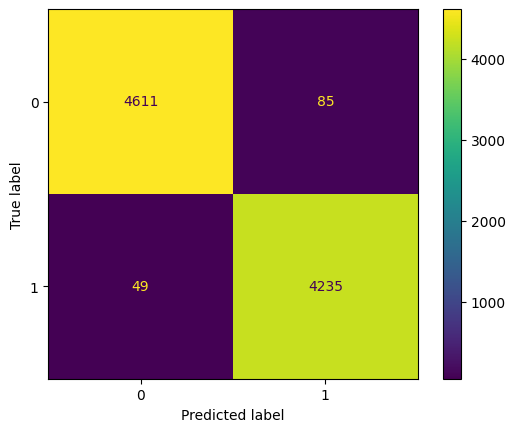

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

# Confusion Matrix Interpretation

The confusion matrix helps me see **where** the model is making mistakes.

- The **rows** show the *true* class (0 = fake, 1 = real).
- The **columns** show the *predicted* class.

From the matrix:

- Top-left cell (0 predicted as 0):  
  the model correctly classified **4,610** fake articles as fake.
- Bottom-right cell (1 predicted as 1):  
  the model correctly classified **4,236** real articles as real.
- Top-right cell (0 predicted as 1):  
  **86** fake articles were incorrectly predicted as real.
- Bottom-left cell (1 predicted as 0):  
  **48** real articles were incorrectly predicted as fake.

So out of almost 9,000 test articles, only a small number are misclassified.  
Most of the mass is on the diagonal, which confirms that the model is working very well.

From a practical point of view:

- **Fake as real (86 cases)** is the more dangerous type of error,  
  because a fake news article would be treated as if it were trustworthy.
- **Real as fake (48 cases)** is also an error, but less risky:  
  a real article is flagged as suspicious.

In future iterations, I could try to reduce the number of “fake → real” errors  
by tuning the decision threshold or using a model that focuses more on recall for the fake class.


# Conclusion and Next Steps

In this project I built a complete fake news detection pipeline:

1. loaded and combined fake and real news articles,
2. cleaned the raw text with a simple NLP preprocessing function,
3. converted the text into TF-IDF features,
4. trained a Logistic Regression classifier,
5. evaluated the model using accuracy, precision, recall, F1-score and a confusion matrix.

Even though I am still at a beginner level, this project shows that:

- I can take a real-world problem,
- turn it into a machine learning task,
- and explain each step in a clear and structured way.

**Possible next steps:**

- try n-grams and other algorithms (LinearSVC, Naive Bayes),
- experiment with modern transformer models such as BERT,
- build a small app (e.g. with Streamlit) where users can paste a news article  
  and get a fake/real prediction.



In [ ]:
# Source : https://www.kaggle.com/code/smailakgz/fake-news-classification